# BIEEGL_Lab

In [222]:
import os
import glob as glob
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from datetime import datetime
from dateutil.parser import parse

### Utility Function: Converts LogFile into 3 tables  

In [219]:

def logFile2Table(path):
    '''
    logFile2Table function takes log file and outputs Following:
    1) Header string from the log file which records time stamp
    2) Event Table
    3) response table
    '''
#     infile = r'/Users/manasibhogawar/Desktop/BEEIGL/logfiles/02_S0300_v0-r3hvAm.log'
    infile = path
    with open(infile) as f:
        f = f.readlines()
    imp = []
    important1 = []
    important2 = []

    read = True
    for line in f:
        if line.startswith("Subject\tTrial\t"):
            read = False

        if read:
            imp.append(line)

    header_table = [l.rstrip() for l in imp if l != ' '][:-1]
    #header_table.head()


    # Fetching log file data of Event table
    for line in f:
        if line.startswith("Subject\tTrial\t") :
            read = False
        elif line.startswith("Event Type\tCode"):
            read = True
    #     if line.startswith("Event Type\tCode"):
    # #         endofLines = True
    #     if not line.startswith("Event Type\tCode") or nextlines:
        if read:
            important2.append(line)

    l2 = [l.rstrip().split('\t') for l in important2 if l != '\n']
    event_table = pd.DataFrame(l2)
    event_table.head()
    ##event_table.info()


    # Fetching log file data of Event table
    read = False
    for line in f:
        if line.startswith("Subject\tTrial\t") :
            read = True
        elif line.startswith("Event Type\tCode"):
            read = False
    #     if line.startswith("Event Type\tCode"):
    # #         endofLines = True
    #     if not line.startswith("Event Type\tCode") or nextlines:
        if read:
            important1.append(line)

    l1 = [l.rstrip().split('\t') for l in important1 if l != '\n']
    stim_table = pd.DataFrame(l1)
    stim_table.head()

    event_table = event_table.rename(columns=event_table.iloc[0]).drop(event_table.index[0])
    stim_table = stim_table.rename(columns=stim_table.iloc[0]).drop(stim_table.index[0])

    return event_table, stim_table, header_table



### Function to calculate, reposne time, # of hits, misses and false alarm 

In [123]:

def Statscal(b):
    '''
    This function takes reponse table and calculates
    response time column, # of hits, misses and false alarm.
    '''
    #Calculating response time
    b['ResponseTime'] = b.Time.diff()
    response_time = b.loc[b['Event Type'] == "Response"]
    #Count of number of Hits for vertical targets
    b["VerticalblueImage"] = b['Code'].str.contains('blue0')   #this will mark column where code is something like blue*
    b["HorizontalblueImage"] = b['Code'].str.contains('blue1')
    b["isHit"] = "No Hits"     # by default we mark all as no hit
    # in this loop we will check if the row which has blue image also have ["Event Type"]=='Response' in next row.
    #then mark that row as hit
    for i in range(1,len(b)):
        currentrow = b.iloc[i]
        if (i+1<len(b)):
            nextrow = b.iloc[i+1]
        if currentrow["VerticalblueImage"] and (nextrow["Event Type"]=='Response'):
            b.loc[i,["isHit"]]="VerticalTargetHit"
        if currentrow["HorizontalblueImage"] and (nextrow["Event Type"]=='Response'):
            b.loc[i,["isHit"]]="HorizontalTargetHit"

#             b["isHit"] = (b["VerticalblueImage"]=="VerticalTargetHit")
#             b["isHit"] = (b["HorizontalblueImage"]=="HorizontalTargetHit")
    VerticalHits = (b.isHit == "VerticalTargetHit").sum()
    HorizontalHits = (b.isHit == "HorizontalTargetHit").sum()
    Hits = VerticalHits + HorizontalHits

    #Count the number of false alarm
    b["VerticalfullImage"] = b['Code'].str.contains('full0')   #this will mark column where code is something like full*
    b["HorizontalfullImage"] = b['Code'].str.contains('full1')
    b["isFalseAlarm"] = "No FalseAlarm"     # by default we mark all as no false alarm
    # in this loop we will check if the row which has full image also have ["Event Type"]=='Response' in next row. then mark that
    # row as false alarm
    for i in range(1,len(b)):
        currentrow = b.iloc[i]
        if (i+1<len(b)):
            nextrow = b.iloc[i+1]
        if currentrow["VerticalfullImage"] and (nextrow["Event Type"]=='Response'):
            b.loc[i,["isFalseAlarm"]]="VerticalFalseAlarm"
        if currentrow["HorizontalfullImage"] and (nextrow["Event Type"]=='Response'):
            b.loc[i,["isFalseAlarm"]]="HorizontalFalseAlarm"

    VerticalFalse_Alarm = (b.isFalseAlarm == "VerticalFalseAlarm").sum()
    HorizontalFalse_Alarm = (b.isFalseAlarm == "HorizontalFalseAlarm").sum()
    False_Alarm = VerticalFalse_Alarm + HorizontalFalse_Alarm

    #Count of number of  Target Miss
    b["VerticalblueImage"] = b['Code'].str.contains('blue0')   #this will mark column where code is something like blue*
    b["HorizontalblueImage"] = b['Code'].str.contains('blue1')
    b["isMiss"] = "No Miss"     # by default we mark all as no hit
    # in this loop we will check if the row which has blue image also have ["Event Type"]=='Response' in next row. then mark that
    # row as hit
    for i in range(1,len(b)):
        currentrow = b.iloc[i]
        if (i+1<len(b)):
            nextrow = b.iloc[i+1]
        if currentrow["VerticalblueImage"] and (nextrow["Event Type"]!='Response'):
             b.loc[i,["isMiss"]]="VerticalTargetMiss"
        if currentrow["HorizontalblueImage"] and (nextrow["Event Type"]!='Response'):
            b.loc[i,["isMiss"]]="HorizontalTargetMiss"

    VerticalMiss_Counts = (b.isMiss == "VerticalTargetMiss").sum()
    HorizontalMiss_Counts = (b.isMiss == "HorizontalTargetMiss").sum()
    Miss_Counts = VerticalMiss_Counts + HorizontalMiss_Counts

    return response_time["ResponseTime"].dropna().to_list() ,Hits, False_Alarm, Miss_Counts


def single_subject(log_path, subject):
    #main function which calls all other utility functions

    inprocess = os.path.join(log_path, 'Temp')
    if not os.path.exists(inprocess):
        os.mkdir(inprocess)
    # "/Users/manasibhogawar/Desktop/Temp/"  # INprocess directory stores all tables in csv format
    timestamps_table = {}
    Response_table = {}
    hits= {}
    miss={}
    falseAlarm={}
    ordered_timestamps = {}
#     print("Inside single subject")
#     print("search Path: ", os.path.join(log_path, subject, '*.log'))

    filenames = glob.glob(os.path.join(log_path, (subject +'*.log')))
#     print(filenames)
    # filenames

    def logtime(c):
        time_stamp = c[1].split(' - ')[1]
        return parse(time_stamp)

    def sortTimeStamps(timestamps_table):
        for value in sorted(timestamps_table):
            ordered_timestamps[value] = timestamps_table[value]

    for file in filenames:
        a, b, c = logFile2Table(file)
        b_tempcsvName = os.path.join(inprocess, os.path.basename(file).replace(".log", "b.csv"))
#         print(b_tempcsvName)
        b.to_csv(b_tempcsvName)
        b = pd.read_csv(b_tempcsvName)
        del b["Unnamed: 0"]
        #indexing b by adding new SrNo integer column to the table
        b.insert(0, "SrNo", list(range(0,len(b))), False)
        b.set_index("SrNo")
        f = os.path.basename(file)
        timestamps_table[logtime(c)] =  f
        Response_table[f], hits[f], falseAlarm[f], miss[f] = Statscal(b)
    sortTimeStamps(timestamps_table)

    #following list contains logfiles which are preHFS and postHFS
    preHFS = [ordered_timestamps[x] for x in list(ordered_timestamps.keys())[0:2]]
    postHFS = [ordered_timestamps[x] for x in list(ordered_timestamps.keys())[2:]]
    ResponseDF = pd.DataFrame.from_dict(Response_table, orient='index').transpose()

    # plot Number of Hits plot
    preHFS_hits = []
    postHFS_hits = []
    for k,v in hits.items():
        if k in preHFS:
            preHFS_hits.append(hits[k])

        if k in postHFS:
            postHFS_hits.append(hits[k])


#     fig_dims = (7,5)
#     fig, ax = plt.subplots(figsize=fig_dims)
    df1=pd.DataFrame(preHFS_hits)
    df2=pd.DataFrame(postHFS_hits)
    df1['hue']= "PreHFS_Hits"
    df2['hue']= "PostHFS_Hits"
    res_hits=pd.concat([df1,df2])
    res_hits.insert(0, "Run", range(1,5), True)
    res_hits.rename(columns = { 0 :'NumberOfHits'}, inplace = True)
#     sns.barplot(data=res_hits, x= 'Run', y = 'NumberOfHits', hue = 'hue' )
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.show()

    # plot Response times
    ResponseDF = ResponseDF[preHFS+postHFS]
#     hm = sns.boxplot(x="variable", y="value", data=pd.melt(ResponseDF), palette=["b", "b","g","g"])
#     # palette=["b", "b","g","g"]
#     hm.set_xticklabels(labels=ResponseDF.columns.values, rotation=30)

    # plot number of False Alarm
    preHFS_falseAlarm = []
    postHFS_falseAlarm = []
    for k,v in falseAlarm.items():
        if k in preHFS:
            preHFS_falseAlarm.append(falseAlarm[k])

        if k in postHFS:
            postHFS_falseAlarm.append(falseAlarm[k])

#     fig_dims = (7,5)
#     fig, ax = plt.subplots(figsize=fig_dims)
    df1=pd.DataFrame(preHFS_falseAlarm)
    df2=pd.DataFrame(postHFS_falseAlarm)
    df1['hue']= "PreHFS_FalseAlarm"
    df2['hue']= "PostHFS_falseAlarm"
    res_false=pd.concat([df1,df2])
    res_false.insert(0, "Run", range(1,5), True)
    res_false.rename(columns = { 0 :'NumberOfFalseAlarm'}, inplace = True)
#     sns.barplot(data=res_false, x= 'Run', y = 'NumberOfFalseAlarm', hue = 'hue' )
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.show()

    #Number of Miss plot
    preHFS_Miss = []
    postHFS_Miss = []
    for k,v in miss.items():
        if k in preHFS:
            preHFS_Miss.append(miss[k])

        if k in postHFS:
            postHFS_Miss.append(miss[k])

#     fig_dims = (7,5)
#     fig, ax = plt.subplots(figsize=fig_dims)
    df1=pd.DataFrame(preHFS_Miss)
    df2=pd.DataFrame(postHFS_Miss)
    df1['hue']= "PreHFS_Miss"
    df2['hue']= "PostHFS_Miss"
    res_miss=pd.concat([df1,df2])
    res_miss.insert(0, "Run", range(1,5), True)
    res_miss.rename(columns = { 0 :'NumberOfMiss'}, inplace = True)
#     sns.barplot(data=res_miss, x= 'Run', y = 'NumberOfMiss', hue = 'hue' )
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.show()
    return ResponseDF, res_hits, res_miss, res_false, ordered_timestamps

## Main function

In [220]:

allResponsetimes_mean = {}
allResponsetimes_median = {}
hits = {}
misses= {}
falsealarms ={}

# allResponsetimes_mean.append(ResponseDF.mean().to_list())
subjects_list = ['01_S0308_v0', '01_S0310_v0', '01_S0325_v0', '01_S0327_v0','02_S0300_v0', 
                 '02_S0324_v0', '02_S0325_v0', '03_S0316_v0', '03_S0320_v0', '03_S0329_v0']
logfiles = '/Users/manasibhogawar/Desktop/BEEIGL/logfiles/'

for sub in subjects_list:
    print("working on sub:  ", sub)
    subj_response, hit, miss, falseAla, order_time = single_subject(logfiles, sub) 
    allResponsetimes_mean[sub] = subj_response.mean().to_list()
    allResponsetimes_median[sub] = subj_response.median().to_list()
    
    hits[sub] = hit["NumberOfHits"].to_list()
    misses[sub] = miss["NumberOfMiss"].to_list()
    falsealarms[sub] = falseAla["NumberOfFalseAlarm"].to_list()
    plt.close()
#     sns.close()
   
# plotting
# sns.boxplot(data= pd.DataFrame(allResponsetimes_mean).transpose())
# sns.boxplot(data= pd.DataFrame(allResponsetimes_median).transpose())

    

working on sub:   01_S0308_v0
working on sub:   01_S0310_v0
working on sub:   01_S0325_v0
working on sub:   01_S0327_v0
working on sub:   02_S0300_v0
working on sub:   02_S0324_v0
working on sub:   02_S0325_v0
working on sub:   03_S0316_v0
working on sub:   03_S0320_v0
working on sub:   03_S0329_v0


## Plots and Inferences

### Mean Response Time for PreHFS and PostHFS

[Text(0, 0.5, 'Response Time (Tenth of ms)'),
 Text(0.5, 0, 'Runs'),
 Text(0.5, 1.0, 'Mean Response Time for PreHFS and PostHFS')]

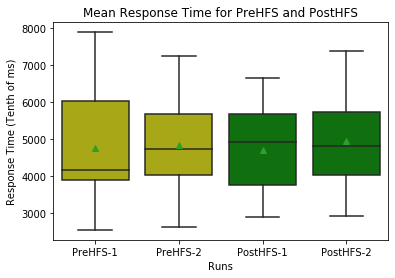

In [170]:
# sns.violinplot(data= pd.DataFrame(allResponsetimes_mean).transpose())
response_df = pd.DataFrame(allResponsetimes_mean).transpose().rename(columns={0: "PreHFS-1", 1: "PreHFS-2", 2:"PostHFS-1",3:"PostHFS-2" })
response_mean = sns.boxplot(data= response_df, showmeans=True, palette=['y', 'y', 'g', 'g'])
response_mean.set(xlabel='Runs', ylabel='Mean Response Time (Tenth of ms)', title='Mean Response Time for PreHFS and PostHFS')

In the above graph i have plotted mean response time of all runs for 10 subjects. Mean(denoted by green triangle) doesnt show much variation however, median value of mean response time shows slight increase. 

As mean is affected by outliers, i have plotted median response time for all subjects in following graph.  

### Median Response Time for PreHFS and PostHFS

[Text(0, 0.5, 'Median Response Time (Tenth of ms)'),
 Text(0.5, 0, 'Runs'),
 Text(0.5, 1.0, 'Median Response Time for PreHFS and PostHFS')]

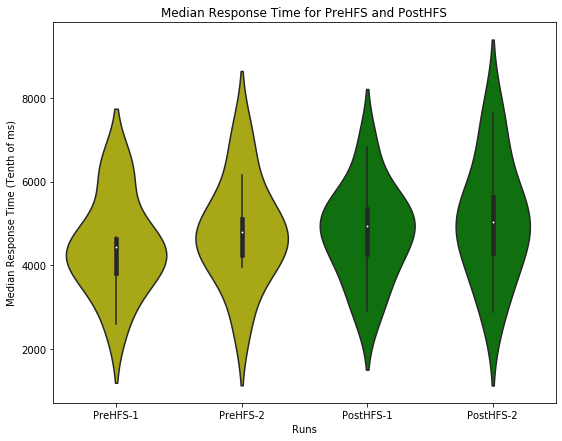

In [200]:
fig, ax = plt.subplots(figsize=(9,7))
response_median_df = pd.DataFrame(allResponsetimes_median).transpose().rename(columns={0: "PreHFS-1", 1: "PreHFS-2", 2:"PostHFS-1",3:"PostHFS-2" })
sns.violinplot(data= response_median_df,showmeans=True, palette=['y', 'y', 'g', 'g'])
ax.set(xlabel='Runs', ylabel='Median Response Time (Tenth of ms)', title='Median Response Time for PreHFS and PostHFS')

In above plot, we have median response time plotted for all 4 runs for ten subjects. From the above violin plot, we can see, there are few subjects for whom median response time has increased in PostHFS-2 run. Those could very well be outliers. Further investigation may give a more concrete picture. Also, for all runs, medial response time follows a normal distribution.  

### Number of Hits for PreHFS and Post HFS

[Text(0, 0.5, 'Number of Hits'),
 Text(0.5, 0, 'Runs'),
 Text(0.5, 1.0, 'Number of Hits for PreHFS and Post HFS')]

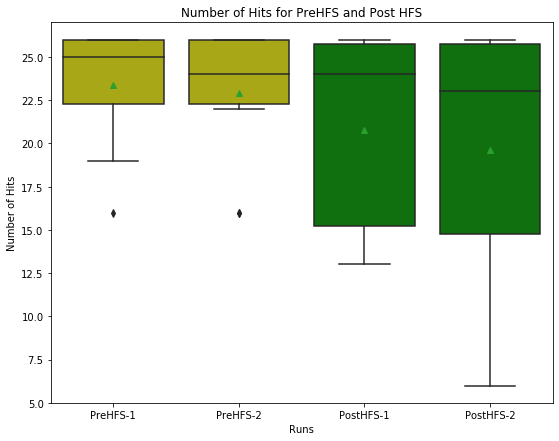

In [202]:
fig, ax = plt.subplots(figsize=(9,7))
hitsAll_df = pd.DataFrame(hits).transpose().rename(columns={'': "Subjects",0: "PreHFS-1", 1: "PreHFS-2", 2:"PostHFS-1",3:"PostHFS-2" })
sns_hits = sns.boxplot(data= hitsAll_df, showfliers=True, showmeans=True, palette=['y', 'y', 'g', 'g'])
ax.set(xlabel='Runs', ylabel='Number of Hits', title='Number of Hits for PreHFS and Post HFS')

In the above plot, i have plotted # of hits for preHFS and PostHFS runs. From the mean of # of hits, we can infer that for some subjects number of hits has reduced significantly. 

###  Number of Misses for PreHFS and Post HFS

[Text(0, 0.5, 'Number of Misses'),
 Text(0.5, 0, 'Runs'),
 Text(0.5, 1.0, 'Number of Misses for PreHFS and Post HFS')]

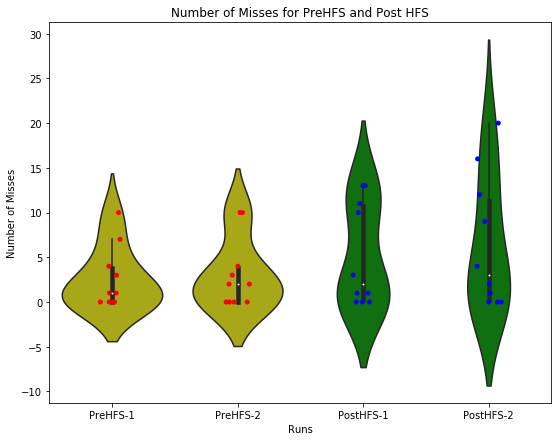

In [213]:
fig_miss, ax_miss = plt.subplots(figsize=(9,7))
misses_df = pd.DataFrame(misses).transpose().rename(columns={'': "Subjects",0: "PreHFS-1", 1: "PreHFS-2", 2:"PostHFS-1",3:"PostHFS-2" })
ax_miss=sns.stripplot(data= misses_df, palette=['r', 'r', 'b', 'b'])
sns.violinplot(data= misses_df, showfliers=False, palette=['y', 'y', 'g', 'g'])

ax_miss.set(xlabel='Runs', ylabel='Number of Misses', title='Number of Misses for PreHFS and Post HFS')

In above plot, i have plotted Number of misses of Pre and post HFS runs. Clearly, for few subjects number of misses have increased significantly in postHFS run. 

###  Number of False Alarms for PreHFS and Post HFS

[Text(0, 0.5, '# of False Alarms'),
 Text(0.5, 0, 'Runs'),
 Text(0.5, 1.0, '# of False Alarms for PreHFS and Post HFS')]

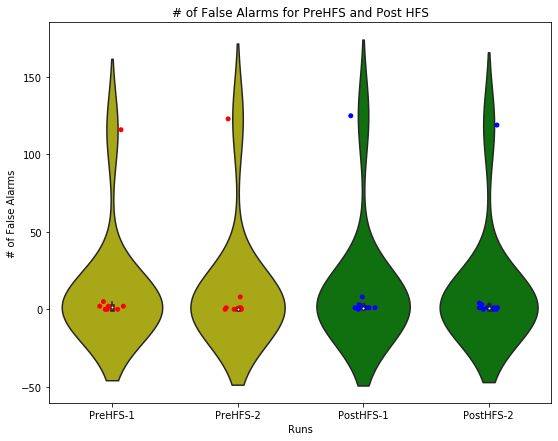

In [217]:

fig_false, ax_false = plt.subplots(figsize=(9,7))
false_df = pd.DataFrame(falsealarms).transpose().rename(columns={'': "Subjects",0: "PreHFS-1", 1: "PreHFS-2", 2:"PostHFS-1",3:"PostHFS-2" })
ax_false=sns.stripplot(data= false_df, palette=['r', 'r', 'b', 'b'])
sns.violinplot(data= false_df, showfliers=False, palette=['y', 'y', 'g', 'g'])

ax_false.set(xlabel='Runs', ylabel='# of False Alarms', title='# of False Alarms for PreHFS and Post HFS')

# sns.boxplot(data= pd.DataFrame(falsealarms).transpose(), showfliers=False)

Looking at above plot, 1 subject is clearly an outlier with numerous false alarm. If we exclude outlier, # of false alarm is almost zero.